## Import libraries

In [8]:
pip install mediapipe

You should consider upgrading via the 'c:\Users\DELL\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [9]:
pip install --upgrade --force-reinstall mediapipe

  Using cached mediapipe-0.10.11-cp38-cp38-win_amd64.whl (50.8 MB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached jax-0.4.13-py3-none-any.whl
  Using cached numpy-1.24.4-cp38-cp38-win_amd64.whl (14.9 MB)
  Using cached protobuf-3.20.3-cp38-cp38-win_amd64.whl (904 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached sounddevice-0.5.1-py3-none-win_amd64.whl (363 kB)
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl (46.2 MB)
  Using cached matplotlib-3.7.5-cp38-cp38-win_amd64.whl (7.5 MB)
  Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
  Using cached cffi-1.17.1-cp38-cp38-win_amd64.whl (181 kB)
  Using cached pycparser-2.22-py3-none-any.whl (117 kB)
  Using cached scipy-1.10.1-cp38-cp38-win_amd64.whl (42.2 MB)
  Using cached ml_dtypes-0.2.0-cp38-cp38-win_amd64.whl (938 kB)
  Using cached importlib_metadata-8.5.0-py3-none-any.whl (26 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Using cached zi

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\DELL\\AppData\\Local\\Programs\\Python\\Python38\\Lib\\site-packages\\~~mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\Users\DELL\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [10]:
!pip install mediapipe --no-cache-dir


In [11]:

import pandas as pd
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates



### Image preprocessing

In [12]:
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [13]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    image_drawing_tool = img_dt

    
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


   
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
    
    landmarks = face_landmarks.landmark

   
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [14]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     
    with mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        
        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [15]:
def face_for_yawn(direc="dataset_new/0_FaceImages", face_cas_path="haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [16]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3870


In [17]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
3670


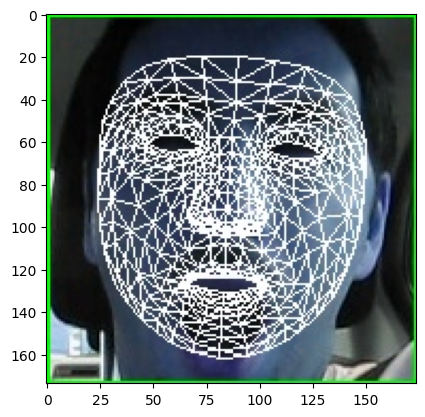

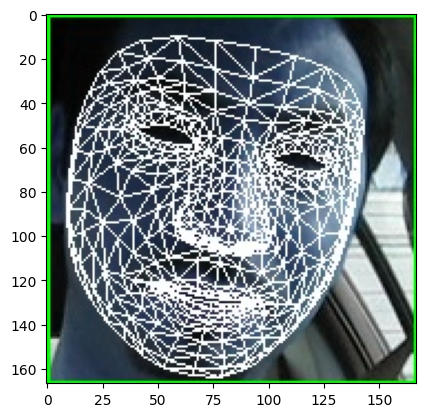

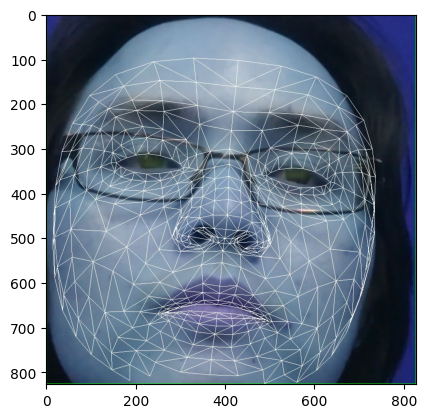

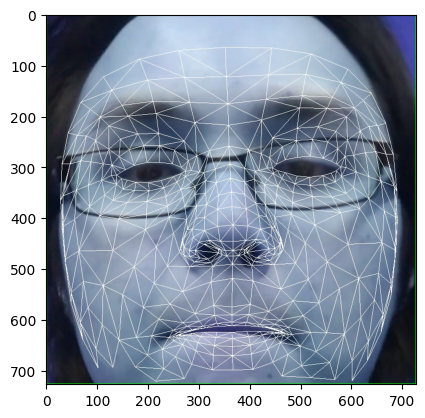

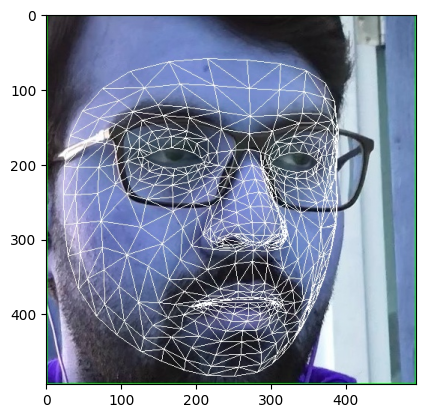

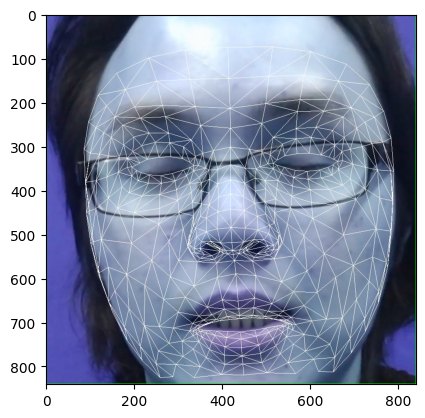

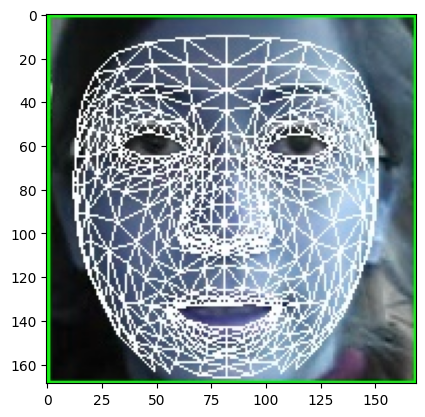

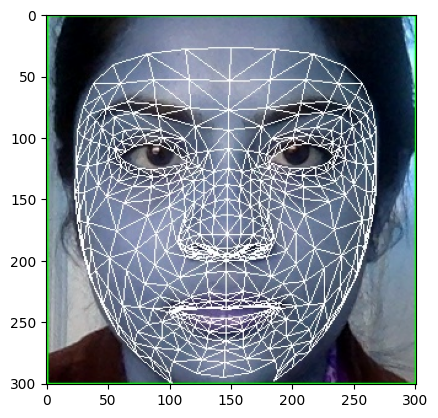

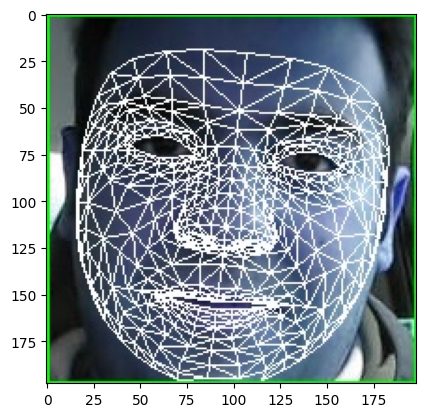

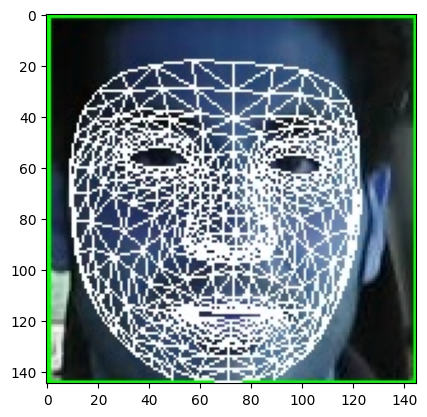

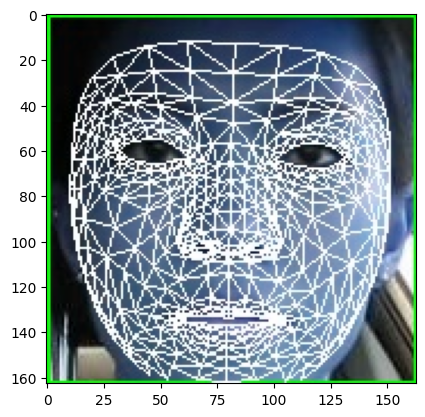

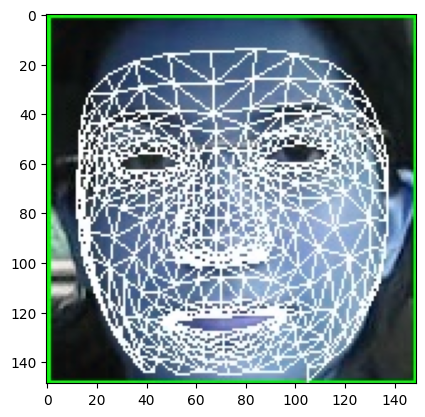

In [18]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

## Resizing Images

In [19]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


## Seperate label and features

In [20]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

## Reshape the array

In [21]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## Label encoder

In [22]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

## Splitting

In [23]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [24]:
len(X_test)

1508

In [25]:
len(X_train)

6032

In [26]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Data Augmentation

In [27]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## Model

In [34]:
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras.models import Model  
import keras
from tensorflow.keras.optimizers import Adam  


In [38]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


sequence_length = 10

# --- Data Preparation ---
def reshape_data(data, labels, sequence_length):
    num_sequences = data.shape[0] // sequence_length
    data_sequences = data[:num_sequences * sequence_length].reshape(num_sequences, sequence_length, 145, 145, 3)
    labels_sequences = labels[:num_sequences * sequence_length].reshape(num_sequences, sequence_length)
    labels_sequences = labels_sequences[:, -1] 
    return data_sequences, labels_sequences

class TimeDistributedImageDataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, image_data_generator):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.image_data_generator = image_data_generator

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        for i in range(batch_x.shape[0]):
            for j in range(batch_x.shape[1]):
                batch_x[i, j] = self.image_data_generator.random_transform(batch_x[i, j])

        return batch_x, batch_y


train_datagen = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_datagen = ImageDataGenerator(rescale=1/255)

X_train_sequences, y_train_sequences = reshape_data(X_train, y_train, sequence_length)
X_test_sequences, y_test_sequences = reshape_data(X_test, y_test, sequence_length)

train_generator = TimeDistributedImageDataGenerator(X_train_sequences, y_train_sequences, batch_size=32, image_data_generator=train_datagen)
test_generator = TimeDistributedImageDataGenerator(X_test_sequences, y_test_sequences, batch_size=32, image_data_generator=test_datagen)

# Define the model
model = Sequential([
    TimeDistributed(Conv2D(16, 3, activation='relu', padding='same'), input_shape=(sequence_length, 145, 145, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D()),
    TimeDistributed(Dropout(0.2)),

    TimeDistributed(Conv2D(32, 5, activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D()),
    TimeDistributed(Dropout(0.2)),

    TimeDistributed(Conv2D(64, 7, activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D()),
    TimeDistributed(Dropout(0.3)),

    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

## Training

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


callbacks = [
    ModelCheckpoint(filepath='drowsiness_detection_cnn_lstm_model.h5', save_best_only=True, monitor='val_loss', mode='min'), 
    EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  
]


history = model.fit(
    train_generator,
    epochs=70,
    validation_data=test_generator,
    callbacks=callbacks,
    shuffle=True,  
    verbose=1
)


Epoch 1/70
19/19 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.6418 

c:\Users\DELL\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 241s 13s/step - loss: 0.6216 - accuracy: 0.6418 - val_loss: 0.6987 - val_accuracy: 0.5067 - lr: 2.0000e-04
Epoch 2/70
19/19 [==============================] - 201s 11s/step - loss: 0.6170 - accuracy: 0.6816 - val_loss: 0.6944 - val_accuracy: 0.5267 - lr: 2.0000e-04
Epoch 3/70
19/19 [==============================] - 192s 10s/step - loss: 0.5917 - accuracy: 0.6683 - val_loss: 0.7045 - val_accuracy: 0.5067 - lr: 2.0000e-04
Epoch 4/70
19/19 [==============================] - 202s 11s/step - loss: 0.5909 - accuracy: 0.6783 - val_loss: 0.7370 - val_accuracy: 0.4800 - lr: 2.0000e-04
Epoch 5/70
19/19 [==============================] - 182s 10s/step - loss: 0.5884 - accuracy: 0.6783 - val_loss: 0.7598 - val_accuracy: 0.4867 - lr: 2.0000e-04
Epoch 6/70
19/19 [==============================] - 197s 10s/step - loss: 0.5772 - accuracy: 0.6866 - val_loss: 0.7631 - val_accuracy: 0.4533 - lr: 4.0000e-05
Epoch 7/70
19/19 [==============================] - 196s 

## Testing

In [43]:
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
5/5 [==============================] - 13s 2s/step - loss: 0.6944 - accuracy: 0.5267


{'loss': 0.6943822503089905, 'accuracy': 0.5266666412353516}

## Saving the model

In [ ]:
model.save('drowsiness_detection_cnn_lstm_model.h5')

In [ ]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\DELL\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


Testing the model

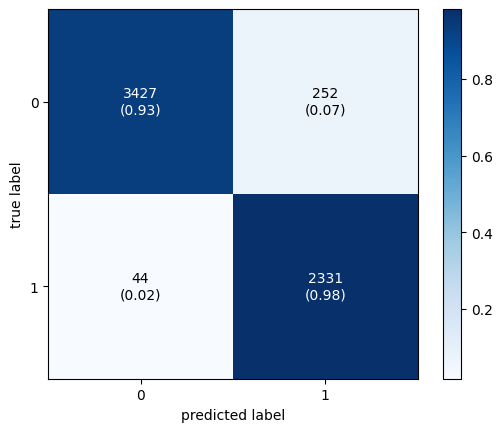

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
binary1 = np.array([[3427,252],[44,2331]])
fig, ax = plot_confusion_matrix(conf_mat=binary1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\DELL\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


### Test the Model of Images from Web

In [44]:
import cv2
import numpy as np
from tensorflow import keras
import urllib.request
import matplotlib.pyplot as plt

In [47]:
model = keras.models.load_model('drowsiness_detection_cnn_lstm_model.h5')

In [50]:
IMG_SIZE = 145
sequence_length = 10  
import urllib.request
import cv2
import numpy as np


image_url = 'https://thumbs.dreamstime.com/b/tired-man-car-sleepy-drowsy-driver-fatigue-driving-sleeping-vehicle-exhausted-bored-drunk-person-serious-upset-331634548.jpg?w=768'
req = urllib.request.urlopen(image_url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1)


image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = image / 255.0  

image_sequence = np.repeat(image[np.newaxis, :, :, :], sequence_length, axis=0)

image_sequence = np.expand_dims(image_sequence, axis=0)

prediction = model.predict(image_sequence)
print("Prediction:", prediction)


1/1 [==============================] - 2s 2s/step
Prediction: [[0.5315429]]


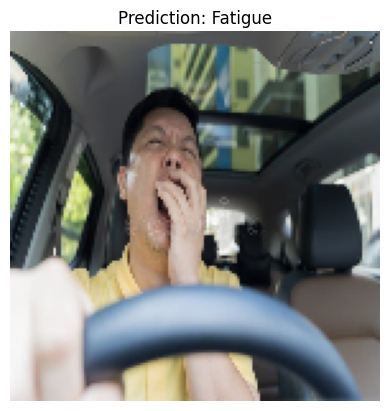

In [52]:
plt.imshow(cv2.cvtColor(cv2.resize(cv2.imdecode(arr, -1), (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB))
plt.title(f'Prediction: {"Fatigue" if prediction[0][0] > 0.5 else "Active"}')
plt.axis('off')
plt.show()

In [53]:
IMG_SIZE = 145
sequence_length = 10  

import urllib.request
import cv2
import numpy as np


image_url = 'https://photos.peopleimages.com/picture/202310/2955857-fitness-city-portrait-and-woman-exercise-determined-and-ready-for-outdoor-cardio-workout-commitment-or-sports.-sweaty-face-road-and-active-athlete-runner-or-person-for-street-training-challenge-zoom_90.jpg'
req = urllib.request.urlopen(image_url)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1)


image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
image = image / 255.0  


image_sequence = np.repeat(image[np.newaxis, :, :, :], sequence_length, axis=0)


image_sequence = np.expand_dims(image_sequence, axis=0)


prediction = model.predict(image_sequence)
print("Prediction:", prediction)


1/1 [==============================] - 0s 269ms/step
Prediction: [[0.5346139]]


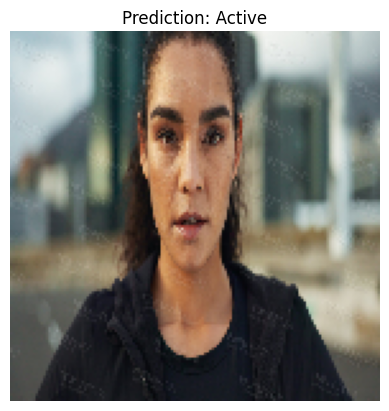

In [ ]:
plt.imshow(cv2.cvtColor(cv2.resize(cv2.imdecode(arr, -1), (IMG_SIZE, IMG_SIZE)), cv2.COLOR_BGR2RGB))
plt.title(f'Prediction: {"Fatigue" if prediction[0][0] < 0.5 else "Active"}')
plt.axis('off')
plt.show()